## Intentaré predecir 12 h en el futuro

In [210]:
# Common imports y set up de cada notebook

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow import keras
import os
import statsmodels.api as sm
from datetime import datetime
import time
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator

# Para imprimir objetos grandes
#np.set_printoptions(threshold = np.inf)

# Para mantener los resultados constantes al ejecutar
np.random.seed(42) # Un random.seed constante

# Para graficar figuras bonitas
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

mpl.rcParams["figure.figsize"] = (12,6.75)
mpl.rcParams["axes.grid"] = False


# Guardar/importar imágenes

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Guardar/importar datos
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
os.makedirs(DATA_PATH, exist_ok=True)

# Guardar datasets
DATASETS = os.path.join(PROJECT_ROOT_DIR, "datasets")
os.makedirs(DATASETS, exist_ok=True)

# Guardar modelos
MODELS = os.path.join(PROJECT_ROOT_DIR, "modelos")
os.makedirs(MODELS, exist_ok=True)

# Funciones 

In [173]:
def plot_real_vs_predicted(Y_real, Y_predicted, x_limits = (0,-1), savefig = False,
                           figname = "figure", formato = "png"):
    
    name = figname + "." + formato
    
    plt.figure(figsize = (12.8,7.2))
    
    y_limits = (np.min([Y_real.min(), Y_predicted.min()]), np.max([Y_real.max(), Y_predicted.max()]))
    plt.ylim(y_limits)
    #y_limits = (Y_real.min(), Y_real.max())
    #plt.ylim(y_limits)
    
    plt.plot(Y_real[x_limits[0]:x_limits[-1]], color = "black", linestyle = "-", linewidth=2, label="Real"), # color = "darkorange",
    plt.plot(Y_predicted[x_limits[0]:x_limits[-1]], "r.-", linewidth=2, label="Predicted")
    plt.legend(loc = 1, fontsize=17)   
    plt.xlabel("Time (1 h)", fontsize=14) 
    plt.ylabel("Consumption", fontsize=14)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = formato, dpi = 200)
    
    plt.show() 
    
def plot_learning_curves(loss, val_loss):
    plt.figure(figsize = (12, 6.75))
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("epoch")
    plt.ylabel("mse")
    plt.grid(True)
    plt.show() 

def plot_train_vs_val(train_errors, val_errors, savefig = False, 
                            figname = "figure", formato = "png"):
        
    name = figname + "." + formato
    
    plt.figure(figsize = (12,6.75))

    y_limits = (np.min([train_errors.min(), val_errors.min()]), np.max([train_errors.max(), val_errors.max()]))
    plt.ylim(y_limits)
        
    plt.plot(train_errors,  "b-.", linewidth=2, label="Training"), # color = "darkorange",
    plt.plot(val_errors, "r-.", linewidth=2, label="Validation")
    plt.legend(loc = 1, fontsize=17)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("mse", fontsize=14)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = formato, dpi = 200)
    
    plt.show() 
    
    
def plot_hours(real, predicted, targets = 1, bloques = 12):
    
    Y_real = []
    Y_predicted = []
    
    a = 0
    for i in range(0, targets*bloques, bloques):
        
        Y_real.extend(real[i])
        Y_predicted.extend(predicted[i])
         
    plt.figure(figsize = (12, 6.75))
    plt.plot(Y_real, color = "black", linestyle = "-", linewidth=2, label="Real")
    plt.plot(Y_predicted,  "r.-", linewidth=2, label="Predicted")
    plt.legend(loc = 1, fontsize=14)    
    plt.xlabel("Time (1 h)", fontsize=14) 
    plt.ylabel("Consumption (normalized)", fontsize=14)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    plt.show()

# Importo los datos

In [174]:
df_train = pd.read_csv(os.path.join(DATASETS, "df_train.csv"))
df_test = pd.read_csv(os.path.join(DATASETS, "df_test.csv"))

formato = '%Y-%m-%d %H'

df_train['Datetime'] = pd.to_datetime(df_train["Datetime"], format=formato, utc = True)
df_train = df_train.set_index(pd.DatetimeIndex(df_train['Datetime']))
df_train.drop(["Datetime"], axis = "columns", inplace = True)

df_test['Datetime'] = pd.to_datetime(df_test["Datetime"], format=formato, utc = True)
df_test = df_test.set_index(pd.DatetimeIndex(df_test['Datetime']))
df_test.drop(["Datetime"], axis = "columns", inplace = True)

useful_features = df_train.columns.to_list()
print(df_train.shape, df_train.columns, "\n")
print(df_test.shape, df_test.columns, "\n")
print(df_train.index.min(), df_train.index.max(), df_test.index.min(), df_test.index.max())

(28051, 38) Index(['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', 'Consumo_MW', 'y + 1', 'y + 2', 'y + 3', 'y + 4',
       'y + 5', 'y + 6', 'y + 7', 'y + 8', 'y + 9', 'y + 10', 'y + 11',
       'y + 12', 'y + 13', 'y + 14', 'y + 15', 'y + 16', 'y + 17', 'y + 18',
       'y + 19', 'y + 20', 'y + 21', 'y + 22', 'y + 23', 'y + 24'],
      dtype='object') 

(7013, 38) Index(['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', 'Consumo_MW', 'y + 1', 'y + 2', 'y + 3', 'y + 4',
       'y + 5', 'y + 6', 'y + 7', 'y + 8', 'y + 9', 'y + 10', 'y +

# Preparación de los datasets

In [237]:
# Selecciono las columnas para multi step forecasting

df_train = df_train.iloc[:,:-12].dropna() #todas las columnas, de y + 1 a y + 12
df_test = df_test.iloc[:,:-12].dropna()
df_train.iloc[:,:]

,total_generation,money_spent,hour,generation_hydro_pumped_storage_consumption,price_actual,generation_solar,generation_fossil_gas,x14_01d,x12_01n,generation_hydro_water_reservoir,x14_01n,humidity_Va,humidity_Ba,Consumo_MW
Datetime,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,2.83e+04,1.85e+06,23,8.63e+02,6.54e+01,4.90e+01,4.84e+03,0.00e+00,1.00e+00,1.90e+03,1.00e+00,77,100,2.54e+04
2015-01-01 00:00:00+00:00,2.78e+04,1.81e+06,0,9.20e+02,6.49e+01,5.00e+01,5.20e+03,0.00e+00,1.00e+00,1.66e+03,1.00e+00,77,100,2.44e+04
2015-01-01 01:00:00+00:00,2.68e+04,1.73e+06,1,1.16e+03,6.45e+01,5.00e+01,4.86e+03,0.00e+00,1.00e+00,1.37e+03,1.00e+00,78,100,2.27e+04
2015-01-01 02:00:00+00:00,2.52e+04,1.50e+06,2,1.50e+03,5.93e+01,5.00e+01,4.31e+03,0.00e+00,1.00e+00,7.79e+02,1.00e+00,78,100,2.13e+04
2015-01-01 03:00:00+00:00,2.46e+04,1.38e+06,3,1.83e+03,5.60e+01,4.20e+01,4.13e+03,0.00e+00,1.00e+00,7.20e+02,1.00e+00,78,100,2.03e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-14 01:00:00+00:00,2.78e+04,1.22e+06,1,1.39e+03,4.39e+01,1.50e+01,3.75e+03,0.00e+00,1.00e+00,4.10e+03,0.00e+00,82,93,2.44e+04
2018-03-14 02:00:00+00:00,2.77e+04,1.19e+06,2,1.32e+03,4.29e+01,1.40e+01,3.73e+03,0.00e+00,1.00e+00,4.14e+03,0.00e+00,81,93,2.40e+04
2018-03-14 03:00:00+00:00,2.83e+04,1.21e+06,3,1.63e+03,4.27e+01,1.50e+01,4.00e+03,0.00e+00,1.00e+00,4.26e+03,0.00e+00,76,87,2.39e+04


In [177]:
# Selecciono las columnas

X_Y_train = df_train.to_numpy()
X_Y_test = df_test.to_numpy()
X_test = X_Y_test[:,:-12]
Y_test = X_Y_test[:,-12:]


# Hago la división en train y val

from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Hacer train_test_split con shuffle = False y random_state = cte sirve para dividir time series

X_train, X_val, Y_train, Y_val = train_test_split(X_Y_train[:,:-12], X_Y_train[:,-12:],
                                                  test_size = 0.25, random_state = 42, shuffle = False)

In [178]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((21029, 14), (21029, 12), (7001, 14), (7001, 12))

In [179]:
# Escalo la data a un rango [0, 1]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_Y_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(Y_train)], axis = 1)
#X_Y_train = np.concatenate([X_train, np.expand_dims(Y_train, axis=1)], axis = 1)
X_Y_train = scaler.fit_transform(X_Y_train)

X_Y_val = pd.concat([pd.DataFrame(X_val), pd.DataFrame(Y_val)], axis = 1)
#X_Y_val = np.concatenate([X_val, np.expand_dims(Y_val, axis=1)], axis = 1)
X_Y_val = scaler.transform(X_Y_val)

X_Y_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(Y_test)], axis = 1)
#X_Y_test = np.concatenate([X_test, np.expand_dims(Y_test, axis=1)], axis = 1)
X_Y_test = scaler.transform(X_Y_test)

In [180]:
X_Y_train[:,:-12].shape, X_Y_train[:,-12:].shape, X_Y_val[:,:-12].shape, X_Y_val[:,-12:].shape, X_Y_test[:,:-12].shape, X_Y_test[:,-12:].shape

((21029, 14), (21029, 12), (7010, 14), (7010, 12), (7001, 14), (7001, 12))

In [181]:
# Lo convierto en un problema de ML

win_len = 24            # Intento predecir el consumo durante las próximas 24 h, con 24 h de antelación
tamaño_del_batch = 64
number_of_features = 14
horizonte = 12
sep = 1

# series

train_ts_generator = TimeseriesGenerator(X_Y_train[:,:-12], X_Y_train[:,-12:], length = win_len, sampling_rate = 1,
                                         batch_size = tamaño_del_batch, stride = sep)

val_ts_generator = TimeseriesGenerator(X_Y_val[:,:-12], X_Y_val[:,-12:], length = win_len, sampling_rate = 1,
                                       batch_size = tamaño_del_batch, stride = sep)

test_ts_generator = TimeseriesGenerator(X_Y_test[:,:-12], X_Y_test[:,-12:], length = win_len, sampling_rate = 1,
                                         batch_size = tamaño_del_batch, stride = sep)


# length es el tamaño de la ventana
# sampling_rate es cada cuánto consideramos un dato (1 para datos continuos)
# stride es la separación entre una muestra de train y la siguiente 


print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
print(train_ts_generator[0][0].shape, train_ts_generator[0][1].shape)

(21029, 14) (21029, 12) (7010, 14) (7010, 12)
(64, 24, 14) (64, 12)


In [182]:
print("muestra de feature vector:", "\n", train_ts_generator[0][0][0].shape, "\n")
print("muestra de target  vector:", "\n", train_ts_generator[0][-1][0].shape)

muestra de feature vector: 
 (24, 14) 

muestra de target  vector: 
 (12,)


# Modelos de base & tabla de errores

In [183]:
# creo un dataframe para guardar los errores

from sklearn.metrics import mean_squared_error

errores_df = pd.DataFrame()

#naive_train_errors = list()
#naive_val_errors = list()
#naive_test_errors = list()
#
#for i in range(24, len(naive_train.index)):
#    actual = naive_train.iloc[i,:-24].to_numpy()
#    predicted = naive_train.iloc[i,-24:].to_numpy()
#    naive_train_errors.append(mean_squared_error(actual, predicted))
#for i in range(24, len(naive_val.index)):
#    actual = naive_val.iloc[i,:-24].to_numpy()
#    predicted = naive_val.iloc[i,-24:].to_numpy()
#    naive_val_errors.append(mean_squared_error(actual, predicted))
#for i in range(24, len(naive_test.index)):
#    actual = naive_test.iloc[i,:-24].to_numpy()
#    predicted = naive_test.iloc[i,-24:].to_numpy()
#    naive_test_errors.append(mean_squared_error(actual, predicted))
#
#naive_train_errors = np.array(naive_train_errors)
#naive_val_errors   = np.array(naive_val_errors)
#naive_test_errors  = np.array(naive_test_errors)

# El error total del set es la suma (o la media, aún por decidir) de los mse de cada predicción de 24 h

errores_df.loc["naive_1h", "train mse"] = np.nan
errores_df.loc["naive_1h", "val mse"] = np.nan

errores_df.loc["naive_1h", "delta errores"] = np.nan
errores_df.loc["naive_1h", "n params"] = 0
errores_df.loc["naive_1h", "training time (s)"] = np.nan
errores_df.loc["naive_1h", "training prediction time (s)"] = np.nan
errores_df.loc["naive_1h", "validation prediction time (s)"] = np.nan

pd.options.display.float_format = '{:.2e}'.format
#pd.options.display.float_format = '{:.7f}'.format
#pd.reset_option("all")
errores_df.sort_values(by = ["val mse"])

,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
naive_1h,nan,nan,nan,0.00e+00,nan,nan,nan


# Comienzo a probar modelos

### DNN 1

In [184]:
np.random.seed(42)
tf.random.set_seed(42)


dnn_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [win_len, number_of_features]),
    #keras.layers.Dense(24, activation = "relu"),
    keras.layers.Dense(horizonte)                                                      
])

early_stopping = keras.callbacks.EarlyStopping(patience = 5)

dnn_1.compile(loss = "mse", optimizer = "adam") # metrics = ["mse"])
                      
history_dnn_1 = dnn_1.fit(train_ts_generator, epochs = 100, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping])

Epoch 1/100
329/329 [==============================] - 1s 4ms/step - loss: 0.0783 - val_loss: 0.0351
Epoch 2/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0283 - val_loss: 0.0254
Epoch 3/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0204 - val_loss: 0.0201
Epoch 4/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0171 - val_loss: 0.0173
Epoch 5/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0154 - val_loss: 0.0161
Epoch 6/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0145 - val_loss: 0.0154
Epoch 7/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0140 - val_loss: 0.0147
Epoch 8/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0136 - val_loss: 0.0142
Epoch 9/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0133 - val_loss: 0.0140
Epoch 10/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0130 - val_lo

329/329 [==============================] - 1s 3ms/step - loss: 0.0108 - val_loss: 0.0124
Epoch 82/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0108 - val_loss: 0.0124
Epoch 83/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0107 - val_loss: 0.0124
Epoch 84/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0107 - val_loss: 0.0124
Epoch 85/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0107 - val_loss: 0.0124
Epoch 86/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0107 - val_loss: 0.0124
Epoch 87/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0107 - val_loss: 0.0124
Epoch 88/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0107 - val_loss: 0.0124
Epoch 89/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0107 - val_loss: 0.0123
Epoch 90/100
329/329 [==============================] - 1s 3ms/step - loss: 0.0107 - val_loss: 

In [185]:
dnn_1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 336)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 12)                4044      
Total params: 4,044
Trainable params: 4,044
Non-trainable params: 0
_________________________________________________________________


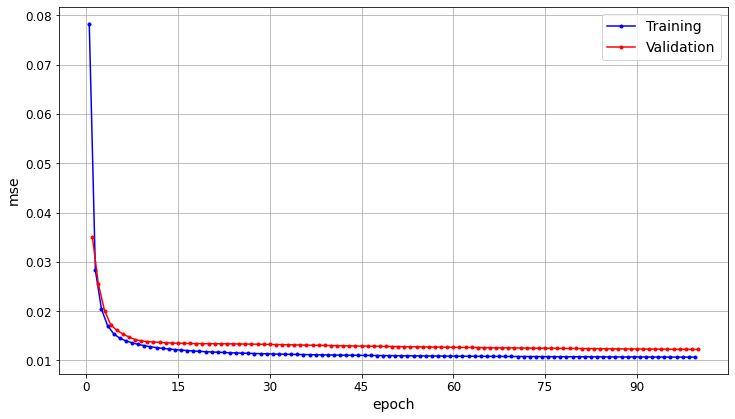

In [186]:
history_dnn_1_df = pd.DataFrame(history_dnn_1.history)

plot_learning_curves(history_dnn_1_df["loss"], history_dnn_1_df["val_loss"])

### Visualizo el training set y el validation set

In [187]:
Y_train_dnn_1 = dnn_1.predict(train_ts_generator)
df_train_dnn_1 = pd.concat([pd.DataFrame(X_Y_train[win_len:,-12:]), pd.DataFrame(Y_train_dnn_1)], axis = 1)

Y_val_dnn_1 = dnn_1.predict(val_ts_generator)
df_val_dnn_1 = pd.concat([pd.DataFrame(X_Y_val[win_len:,-12:]), pd.DataFrame(Y_val_dnn_1)], axis = 1)

# Para des - esclar los datos

#X_Y_train_predicted = scaler.inverse_transform(df_train_predicted)
#X_Y_train_real = scaler.inverse_transform(df_train_real)
#
#df_train_predicted = pd.concat([pd.DataFrame(X_Y_train_predicted[:,:-24]), pd.DataFrame(X_Y_train_predicted[:, -24:])], axis = 1)
#df_train_real = df_train.iloc[24:21020,:]
#df_train_real = pd.concat([pd.DataFrame(X_Y_train_real[24:,:-24]), pd.DataFrame(X_Y_train_real[24:, -24:])], axis = 1)




In [188]:
X_Y_train.shape, Y_train_predicted.shape

((21029, 26), (21005, 12))

In [189]:
errores_df.loc["dnn_1", "train mse"] = dnn_1.evaluate(train_ts_generator)
errores_df.loc["dnn_1", "val mse"] = dnn_1.evaluate(val_ts_generator)
errores_df.loc["dnn_1", "n params"] = dnn_1.count_params()
errores_df.loc["dnn_1", "delta errores"] = np.abs(errores_df.loc["dnn_1", "train mse"]-errores_df.loc["dnn_1", "val mse"])

errores_df.sort_values(by = ["val mse"])

110/110 [==============================] - 0s 2ms/step - loss: 0.0122


,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
dnn_1,1.25e-02,1.22e-02,2.13e-04,4.04e+03,nan,nan,nan
naive_1h,nan,nan,nan,0.00e+00,nan,nan,nan


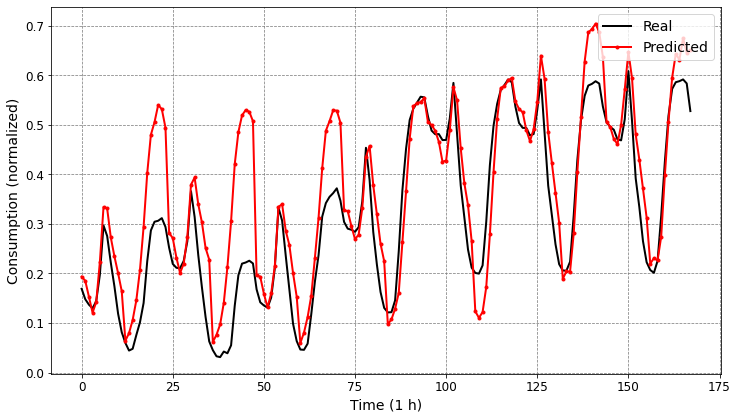

In [203]:
plot_hours(df_train_dnn_1.iloc[-1000:,:-12].to_numpy(), df_train_dnn_1.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

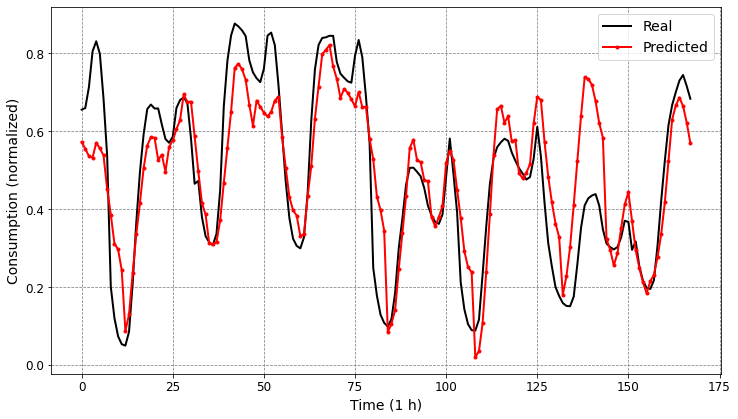

In [204]:
plot_hours(df_val_dnn_1.iloc[-1000:,:-12].to_numpy(), df_val_dnn_1.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

### RNN 2

In [192]:
np.random.seed(42)
tf.random.set_seed(42)


rnn_2 = keras.models.Sequential([
    keras.layers.SimpleRNN(48, input_shape = [win_len, number_of_features], activation = "relu",
                           return_sequences = True),
    keras.layers.SimpleRNN(24, input_shape = [win_len, number_of_features], activation = "relu",
                           return_sequences = True),
    keras.layers.SimpleRNN(24, input_shape = [win_len, number_of_features], activation = "relu"),
    keras.layers.Dense(horizonte)                                                      
])

early_stopping = keras.callbacks.EarlyStopping(patience = 10)

rnn_2.compile(loss = "mse", optimizer = "adam") # metrics = ["mse"])
                      
history_rnn_2 = rnn_2.fit(train_ts_generator, epochs = 50, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping])

Epoch 1/50
329/329 [==============================] - 17s 51ms/step - loss: 0.0521 - val_loss: 0.0300
Epoch 2/50
329/329 [==============================] - 16s 50ms/step - loss: 0.0266 - val_loss: 0.0206
Epoch 3/50
329/329 [==============================] - 16s 49ms/step - loss: 0.0182 - val_loss: 0.0184
Epoch 4/50
329/329 [==============================] - 16s 48ms/step - loss: 0.0143 - val_loss: 0.0156
Epoch 5/50
329/329 [==============================] - 16s 48ms/step - loss: 0.0123 - val_loss: 0.0136
Epoch 6/50
329/329 [==============================] - 16s 49ms/step - loss: 0.0111 - val_loss: 0.0122
Epoch 7/50
329/329 [==============================] - 16s 50ms/step - loss: 0.0103 - val_loss: 0.0115
Epoch 8/50
329/329 [==============================] - 16s 49ms/step - loss: 0.0097 - val_loss: 0.0111
Epoch 9/50
329/329 [==============================] - 16s 50ms/step - loss: 0.0093 - val_loss: 0.0106
Epoch 10/50
329/329 [==============================] - 16s 50ms/step - loss: 0.008

In [193]:
rnn_2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 24, 48)            3024      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 24, 24)            1752      
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 24)                1176      
_________________________________________________________________
dense_7 (Dense)              (None, 12)                300       
Total params: 6,252
Trainable params: 6,252
Non-trainable params: 0
_________________________________________________________________


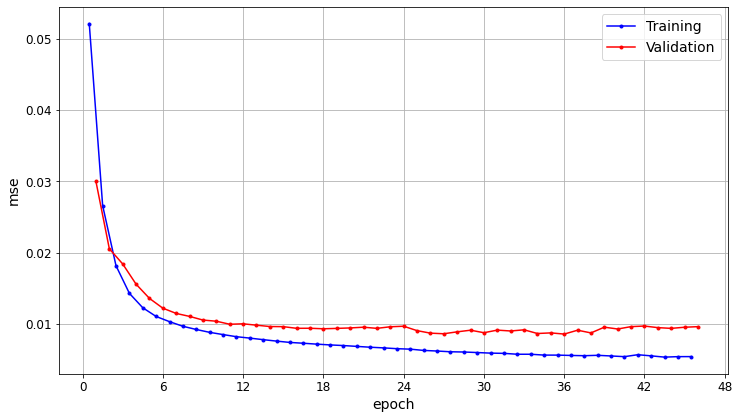

In [194]:
history_rnn_2_df = pd.DataFrame(history_rnn_2.history)

plot_learning_curves(history_rnn_2_df["loss"], history_rnn_2_df["val_loss"])

### Visualizo el training set y el validation set

In [195]:
Y_train_rnn_2 = rnn_2.predict(train_ts_generator)
df_train_rnn_2 = pd.concat([pd.DataFrame(X_Y_train[win_len:,-12:]), pd.DataFrame(Y_train_rnn_2)], axis = 1)

Y_val_rnn_2 = rnn_2.predict(val_ts_generator)
df_val_rnn_2 = pd.concat([pd.DataFrame(X_Y_val[win_len:,-12:]), pd.DataFrame(Y_val_rnn_2)], axis = 1)

# Para des - esclar los datos

#X_Y_train_predicted = scaler.inverse_transform(df_train_predicted)
#X_Y_train_real = scaler.inverse_transform(df_train_real)
#
#df_train_predicted = pd.concat([pd.DataFrame(X_Y_train_predicted[:,:-24]), pd.DataFrame(X_Y_train_predicted[:, -24:])], axis = 1)
#df_train_real = df_train.iloc[24:21020,:]
#df_train_real = pd.concat([pd.DataFrame(X_Y_train_real[24:,:-24]), pd.DataFrame(X_Y_train_real[24:, -24:])], axis = 1)




In [196]:
errores_df.loc["rnn_2", "train mse"] = rnn_2.evaluate(train_ts_generator)
errores_df.loc["rnn_2", "val mse"] = rnn_2.evaluate(val_ts_generator)
errores_df.loc["rnn_2", "n params"] = rnn_2.count_params()
errores_df.loc["rnn_2", "delta errores"] = np.abs(errores_df.loc["rnn_2", "train mse"]-errores_df.loc["rnn_2", "val mse"])

errores_df.sort_values(by = ["val mse"])

110/110 [==============================] - 2s 19ms/step - loss: 0.0096


,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
rnn_2,7.77e-03,9.65e-03,1.88e-03,6.25e+03,nan,nan,nan
dnn_1,1.25e-02,1.22e-02,2.13e-04,4.04e+03,nan,nan,nan
naive_1h,nan,nan,nan,0.00e+00,nan,nan,nan


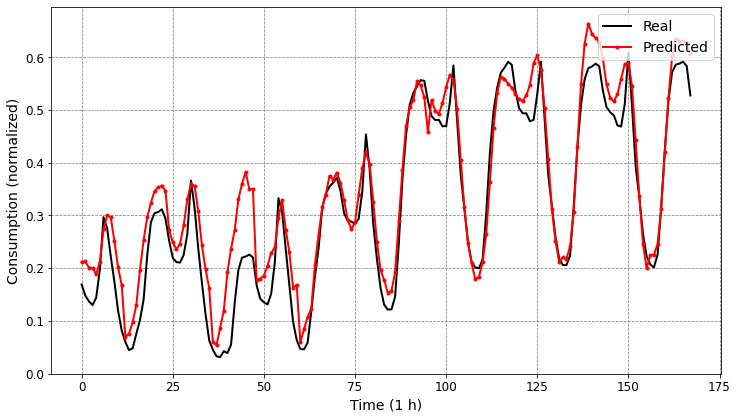

In [205]:
plot_hours(df_train_rnn_2.iloc[-1000:,:-12].to_numpy(), df_train_rnn_2.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

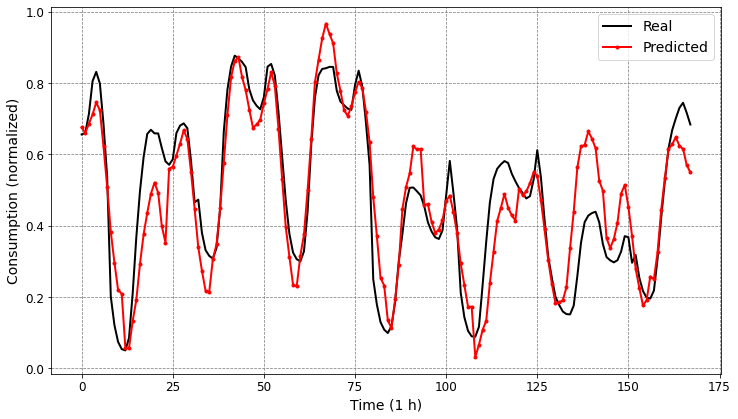

In [208]:
plot_hours(df_val_rnn_2.iloc[-1000:,:-12].to_numpy(), df_val_rnn_2.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

### RNN 1

In [212]:
np.random.seed(42)
tf.random.set_seed(42)


rnn_1 = keras.models.Sequential([
    keras.layers.SimpleRNN(24, input_shape = [win_len, number_of_features],
                           return_sequences = True),
    keras.layers.SimpleRNN(24, input_shape = [win_len, number_of_features]),
    keras.layers.Dense(horizonte)                                                      
])

checkpoint_rnn_1 = keras.callbacks.ModelCheckpoint(os.path.join(MODELS, "rnn_1.h5"), save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience = 10)

rnn_1.compile(loss = "mse", optimizer = "adam") # metrics = ["mse"])
                      
history_rnn_1 = rnn_1.fit(train_ts_generator, epochs = 50, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint_rnn_1])

Epoch 1/50
329/329 [==============================] - 9s 26ms/step - loss: 0.0477 - val_loss: 0.0367
Epoch 2/50
329/329 [==============================] - 8s 24ms/step - loss: 0.0270 - val_loss: 0.0230
Epoch 3/50
329/329 [==============================] - 8s 24ms/step - loss: 0.0195 - val_loss: 0.0170
Epoch 4/50
329/329 [==============================] - 8s 24ms/step - loss: 0.0159 - val_loss: 0.0146
Epoch 5/50
329/329 [==============================] - 8s 24ms/step - loss: 0.0142 - val_loss: 0.0137
Epoch 6/50
329/329 [==============================] - 8s 24ms/step - loss: 0.0132 - val_loss: 0.0131
Epoch 7/50
329/329 [==============================] - 8s 24ms/step - loss: 0.0124 - val_loss: 0.0127
Epoch 8/50
329/329 [==============================] - 7s 23ms/step - loss: 0.0117 - val_loss: 0.0123
Epoch 9/50
329/329 [==============================] - 8s 23ms/step - loss: 0.0111 - val_loss: 0.0120
Epoch 10/50
329/329 [==============================] - 8s 24ms/step - loss: 0.0106 - val_lo

In [ ]:
# Recuperar el modelo si queremos seguir entrenando
# rnn_1 = keras.models.load_model(os.path.join(MODELS, "rnn_1.h5")) recuperar el mejor modelo

In [213]:
rnn_1.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_13 (SimpleRNN)    (None, 24, 24)            936       
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 24)                1176      
_________________________________________________________________
dense_10 (Dense)             (None, 12)                300       
Total params: 2,412
Trainable params: 2,412
Non-trainable params: 0
_________________________________________________________________


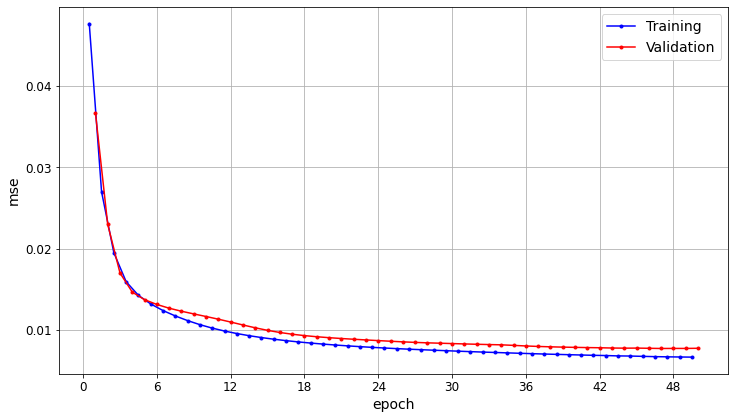

In [214]:
history_rnn_1_df = pd.DataFrame(history_rnn_1.history)


plot_learning_curves(history_rnn_1_df["loss"], history_rnn_1_df["val_loss"])

### Visualizo el training set y el validation set

In [219]:
Y_train_rnn_1  = rnn_1.predict(train_ts_generator)
df_train_rnn_1 = pd.concat([pd.DataFrame(X_Y_train[win_len:,-12:]), pd.DataFrame(Y_train_rnn_1)], axis = 1)

Y_val_rnn_1    = rnn_1.predict(val_ts_generator)
df_val_rnn_1   = pd.concat([pd.DataFrame(X_Y_val[win_len:,-12:]), pd.DataFrame(Y_val_rnn_1)], axis = 1)

In [220]:
errores_df.loc["rnn_1", "train mse"]     = rnn_1.evaluate(train_ts_generator)
errores_df.loc["rnn_1", "val mse"]       = rnn_1.evaluate(val_ts_generator)
errores_df.loc["rnn_1", "n params"]      = rnn_1.count_params()
errores_df.loc["rnn_1", "delta errores"] = np.abs(errores_df.loc["rnn_1", "train mse"]-errores_df.loc["rnn_1", "val mse"])

errores_df.sort_values(by = ["val mse"])

110/110 [==============================] - 1s 9ms/step - loss: 0.0077


,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
rnn_1,7.80e-03,7.74e-03,6.39e-05,2.41e+03,nan,nan,nan
rnn_2,7.77e-03,9.65e-03,1.88e-03,6.25e+03,nan,nan,nan
dnn_1,1.25e-02,1.22e-02,2.13e-04,4.04e+03,nan,nan,nan
naive_1h,nan,nan,nan,0.00e+00,nan,nan,nan


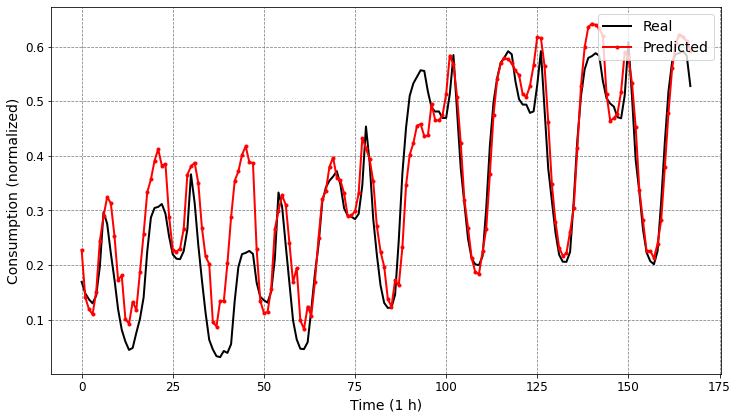

In [221]:
plot_hours(df_train_rnn_1.iloc[-1000:,:-12].to_numpy(), df_train_rnn_1.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

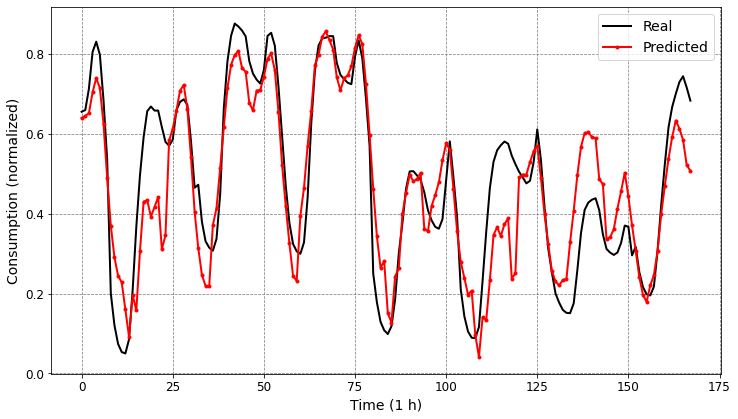

In [222]:
plot_hours(df_val_rnn_1.iloc[-1000:,:-12].to_numpy(), df_val_rnn_1.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

### LSTM 1

In [223]:
np.random.seed(42)
tf.random.set_seed(42)


lstm_1 = keras.models.Sequential([
        keras.layers.LSTM(48, input_shape=[None, number_of_features], return_sequences = True),
        keras.layers.LSTM(24, input_shape=[None, number_of_features], return_sequences = True),
        keras.layers.LSTM(12, input_shape=[None, number_of_features], return_sequences = True),
        keras.layers.LSTM(12, input_shape=[None, number_of_features],),# return_sequences = True),
        #keras.layers.TimeDistributed(keras.layers.Dense(24), input_shape=[win_len, number_of_features])
        keras.layers.Dense(horizonte)                                                      
])

checkpoint_lstm_1 = keras.callbacks.ModelCheckpoint(os.path.join(MODELS, "lstm_1.h5"), save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience = 5)

lstm_1.compile(loss = "mse", optimizer = "adam") # metrics = ["mse"])
                      
history_lstm_1 = lstm_1.fit(train_ts_generator, epochs = 50, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint_lstm_1])

Epoch 1/50
329/329 [==============================] - 64s 193ms/step - loss: 0.0497 - val_loss: 0.0273
Epoch 2/50
329/329 [==============================] - 60s 182ms/step - loss: 0.0223 - val_loss: 0.0201
Epoch 3/50
329/329 [==============================] - 60s 183ms/step - loss: 0.0185 - val_loss: 0.0176
Epoch 4/50
329/329 [==============================] - 60s 183ms/step - loss: 0.0159 - val_loss: 0.0160
Epoch 5/50
329/329 [==============================] - 61s 187ms/step - loss: 0.0137 - val_loss: 0.0145
Epoch 6/50
329/329 [==============================] - 60s 183ms/step - loss: 0.0122 - val_loss: 0.0134
Epoch 7/50
329/329 [==============================] - 60s 183ms/step - loss: 0.0111 - val_loss: 0.0124
Epoch 8/50
329/329 [==============================] - 61s 187ms/step - loss: 0.0103 - val_loss: 0.0115
Epoch 9/50
329/329 [==============================] - 61s 184ms/step - loss: 0.0096 - val_loss: 0.0108
Epoch 10/50
329/329 [==============================] - 59s 180ms/step - l

In [224]:
lstm_1.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 48)          12096     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 24)          7008      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 12)          1776      
_________________________________________________________________
lstm_3 (LSTM)                (None, 12)                1200      
_________________________________________________________________
dense_11 (Dense)             (None, 12)                156       
Total params: 22,236
Trainable params: 22,236
Non-trainable params: 0
_________________________________________________________________


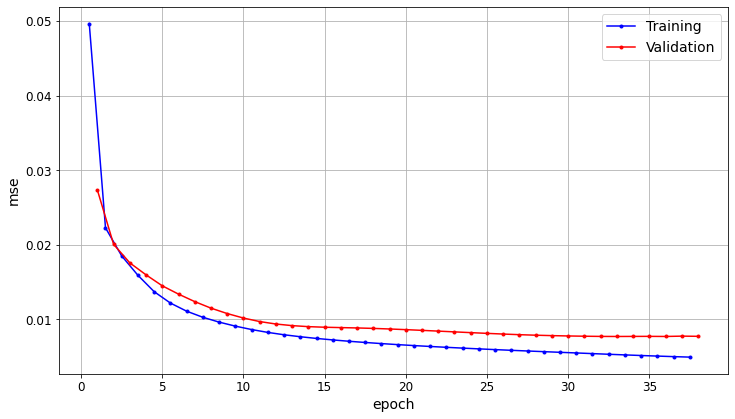

In [225]:
history_lstm_1_df = pd.DataFrame(history_lstm_1.history)


plot_learning_curves(history_lstm_1_df["loss"], history_lstm_1_df["val_loss"])

### Visualizo el training set y el validation set

In [226]:
Y_train_lstm_1  = lstm_1.predict(train_ts_generator)
df_train_lstm_1 = pd.concat([pd.DataFrame(X_Y_train[win_len:,-12:]), pd.DataFrame(Y_train_lstm_1)], axis = 1)

Y_val_lstm_1    = lstm_1.predict(val_ts_generator)
df_val_lstm_1   = pd.concat([pd.DataFrame(X_Y_val[win_len:,-12:]), pd.DataFrame(Y_val_lstm_1)], axis = 1)

In [227]:
errores_df.loc["lstm_1", "train mse"]     = lstm_1.evaluate(train_ts_generator)
errores_df.loc["lstm_1", "val mse"]       = lstm_1.evaluate(val_ts_generator)
errores_df.loc["lstm_1", "n params"]      = lstm_1.count_params()
errores_df.loc["lstm_1", "delta errores"] = np.abs(errores_df.loc["lstm_1", "train mse"]-errores_df.loc["lstm_1", "val mse"])

errores_df.sort_values(by = ["val mse"])

110/110 [==============================] - 7s 61ms/step - loss: 0.0077


,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
lstm_1,6.63e-03,7.73e-03,1.10e-03,2.22e+04,nan,nan,nan
rnn_1,7.80e-03,7.74e-03,6.39e-05,2.41e+03,nan,nan,nan
rnn_2,7.77e-03,9.65e-03,1.88e-03,6.25e+03,nan,nan,nan
dnn_1,1.25e-02,1.22e-02,2.13e-04,4.04e+03,nan,nan,nan
naive_1h,nan,nan,nan,0.00e+00,nan,nan,nan


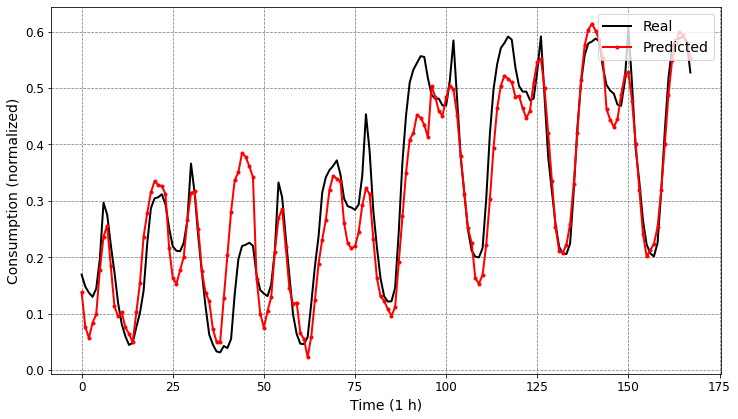

In [228]:
plot_hours(df_train_lstm_1.iloc[-1000:,:-12].to_numpy(), df_train_lstm_1.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

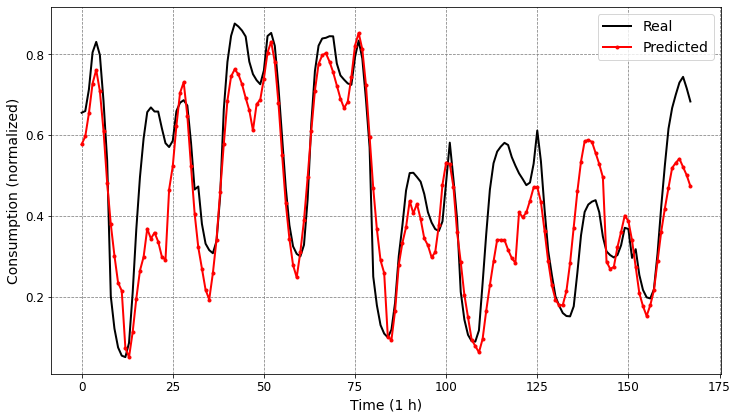

In [229]:
plot_hours(df_val_lstm_1.iloc[-1000:,:-12].to_numpy(), df_val_lstm_1.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

### LSTM 2


Una copia del mejor modelo hasta ahora, RNN1 pero con celdas LSTM

In [230]:
np.random.seed(42)
tf.random.set_seed(42)


lstm_2 = keras.models.Sequential([
    keras.layers.LSTM(24, input_shape = [win_len, number_of_features],
                           return_sequences = True),
    keras.layers.LSTM(24, input_shape = [win_len, number_of_features]),
    keras.layers.Dense(horizonte)                                                      
])

checkpoint_lstm_2 = keras.callbacks.ModelCheckpoint(os.path.join(MODELS, "lstm_2.h5"), save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience = 10)

lstm_2.compile(loss = "mse", optimizer = "adam") # metrics = ["mse"])
                      
history_lstm_2 = lstm_2.fit(train_ts_generator, epochs = 50, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint_lstm_2])

Epoch 1/50
329/329 [==============================] - 26s 79ms/step - loss: 0.0482 - val_loss: 0.0275
Epoch 2/50
329/329 [==============================] - 25s 76ms/step - loss: 0.0208 - val_loss: 0.0172
Epoch 3/50
329/329 [==============================] - 26s 78ms/step - loss: 0.0145 - val_loss: 0.0133
Epoch 4/50
329/329 [==============================] - 25s 77ms/step - loss: 0.0119 - val_loss: 0.0120
Epoch 5/50
329/329 [==============================] - 24s 74ms/step - loss: 0.0106 - val_loss: 0.0114
Epoch 6/50
329/329 [==============================] - 25s 76ms/step - loss: 0.0099 - val_loss: 0.0111
Epoch 7/50
329/329 [==============================] - 25s 76ms/step - loss: 0.0095 - val_loss: 0.0108
Epoch 8/50
329/329 [==============================] - 25s 77ms/step - loss: 0.0091 - val_loss: 0.0106
Epoch 9/50
329/329 [==============================] - 25s 77ms/step - loss: 0.0088 - val_loss: 0.0104
Epoch 10/50
329/329 [==============================] - 26s 78ms/step - loss: 0.008

In [ ]:
# Recuperar el modelo si queremos seguir entrenando
# rnn_1 = keras.models.load_model(os.path.join(MODELS, "lstm_2.h5")) recuperar el mejor modelo

In [231]:
lstm_2.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 24, 24)            3744      
_________________________________________________________________
lstm_5 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_12 (Dense)             (None, 12)                300       
Total params: 8,748
Trainable params: 8,748
Non-trainable params: 0
_________________________________________________________________


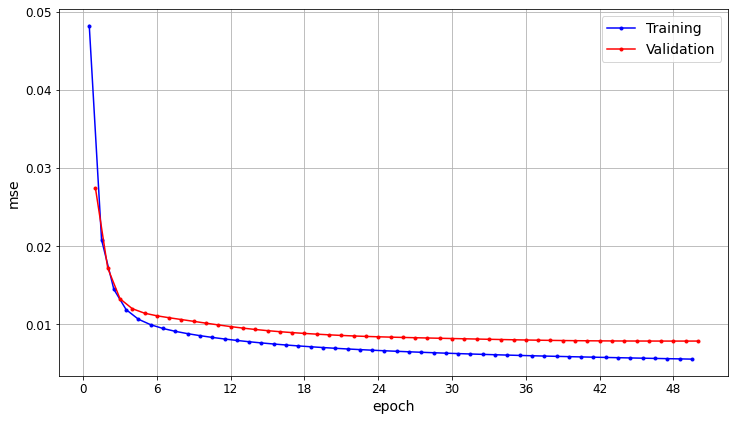

In [232]:
history_lstm_2_df = pd.DataFrame(history_lstm_2.history)


plot_learning_curves(history_lstm_2_df["loss"], history_lstm_2_df["val_loss"])

### Visualizo el training set y el validation set

In [233]:
Y_train_lstm_2  = lstm_2.predict(train_ts_generator)
df_train_lstm_2 = pd.concat([pd.DataFrame(X_Y_train[win_len:,-12:]), pd.DataFrame(Y_train_lstm_2)], axis = 1)

Y_val_lstm_2    = lstm_2.predict(val_ts_generator)
df_val_lstm_2   = pd.concat([pd.DataFrame(X_Y_val[win_len:,-12:]), pd.DataFrame(Y_val_lstm_2)], axis = 1)

In [234]:
errores_df.loc["lstm_2", "train mse"]     = lstm_2.evaluate(train_ts_generator)
errores_df.loc["lstm_2", "val mse"]       = lstm_2.evaluate(val_ts_generator)
errores_df.loc["lstm_2", "n params"]      = lstm_2.count_params()
errores_df.loc["lstm_2", "delta errores"] = np.abs(errores_df.loc["lstm_2", "train mse"]-errores_df.loc["lstm_2", "val mse"])

errores_df.sort_values(by = ["val mse"])

110/110 [==============================] - 3s 26ms/step - loss: 0.0079


,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
lstm_1,6.63e-03,7.73e-03,1.10e-03,2.22e+04,nan,nan,nan
rnn_1,7.80e-03,7.74e-03,6.39e-05,2.41e+03,nan,nan,nan
lstm_2,7.15e-03,7.85e-03,7.07e-04,8.75e+03,nan,nan,nan
rnn_2,7.77e-03,9.65e-03,1.88e-03,6.25e+03,nan,nan,nan
dnn_1,1.25e-02,1.22e-02,2.13e-04,4.04e+03,nan,nan,nan
naive_1h,nan,nan,nan,0.00e+00,nan,nan,nan


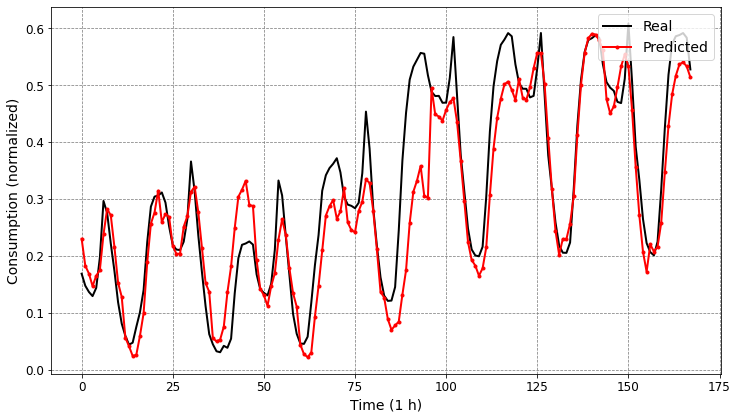

In [235]:
plot_hours(df_train_lstm_2.iloc[-1000:,:-12].to_numpy(), df_train_lstm_2.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

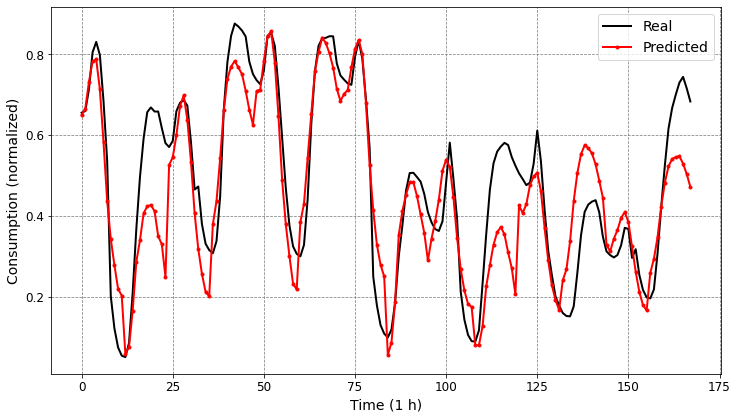

In [236]:
plot_hours(df_val_lstm_2.iloc[-1000:,:-12].to_numpy(), df_val_lstm_2.iloc[-1000:,-12:].to_numpy(),
           targets = 14)